In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob
import pathlib
import tensorflow as tf
import cv2, os, random
from termcolor import colored
from tensorflow.keras.utils import image_dataset_from_directory, plot_model
from tensorflow.keras import layers, losses, optimizers, applications


from warnings import filterwarnings
filterwarnings("ignore")

from sklearn import set_config
set_config(print_changed_only = False)


directory = "D:\Woxsen hackathon\AV\crop"
path_for_data = pathlib.Path(directory)


print(colored("Required libraries were succesfully imported...", color = "green", attrs = ["bold", "dark"]))

Required libraries were succesfully imported...


In [7]:
train_df = image_dataset_from_directory(path_for_data,
                                        image_size = (128, 128),
                                        validation_split = 0.3,
                                        subset = "training",
                                        shuffle = True,
                                        batch_size = 25,
                                        seed = 123)

validation_df = image_dataset_from_directory(path_for_data,
                                             image_size = (128, 128),
                                             validation_split = 0.35,
                                             subset = "validation",
                                             shuffle = True,
                                             batch_size = 25,
                                             seed = 123)

print(colored("The datasets were succesfully loaded...", color = "green", attrs = ["bold", "dark"]))

Found 33872 files belonging to 80 classes.
Using 23711 files for training.
Found 33872 files belonging to 80 classes.
Using 11855 files for validation.
The datasets were succesfully loaded...


In [9]:
train_df, validation_df

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [10]:
print("There is {} images in the training dataset".format(len(train_df)))
print("There is {} images in the validation dataset".format(len(validation_df)))

There is 949 images in the training dataset
There is 475 images in the validation dataset


In [11]:
validation_batches = tf.data.experimental.cardinality(validation_df)
validation_batches

<tf.Tensor: shape=(), dtype=int64, numpy=475>

In [13]:
# take validation batches for test set
test_df = validation_df.take(validation_batches // 5)

# skip validation batches for validation set
validation_df = validation_df.skip(validation_batches // 5)

test_df, validation_df

(<_TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_SkipDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

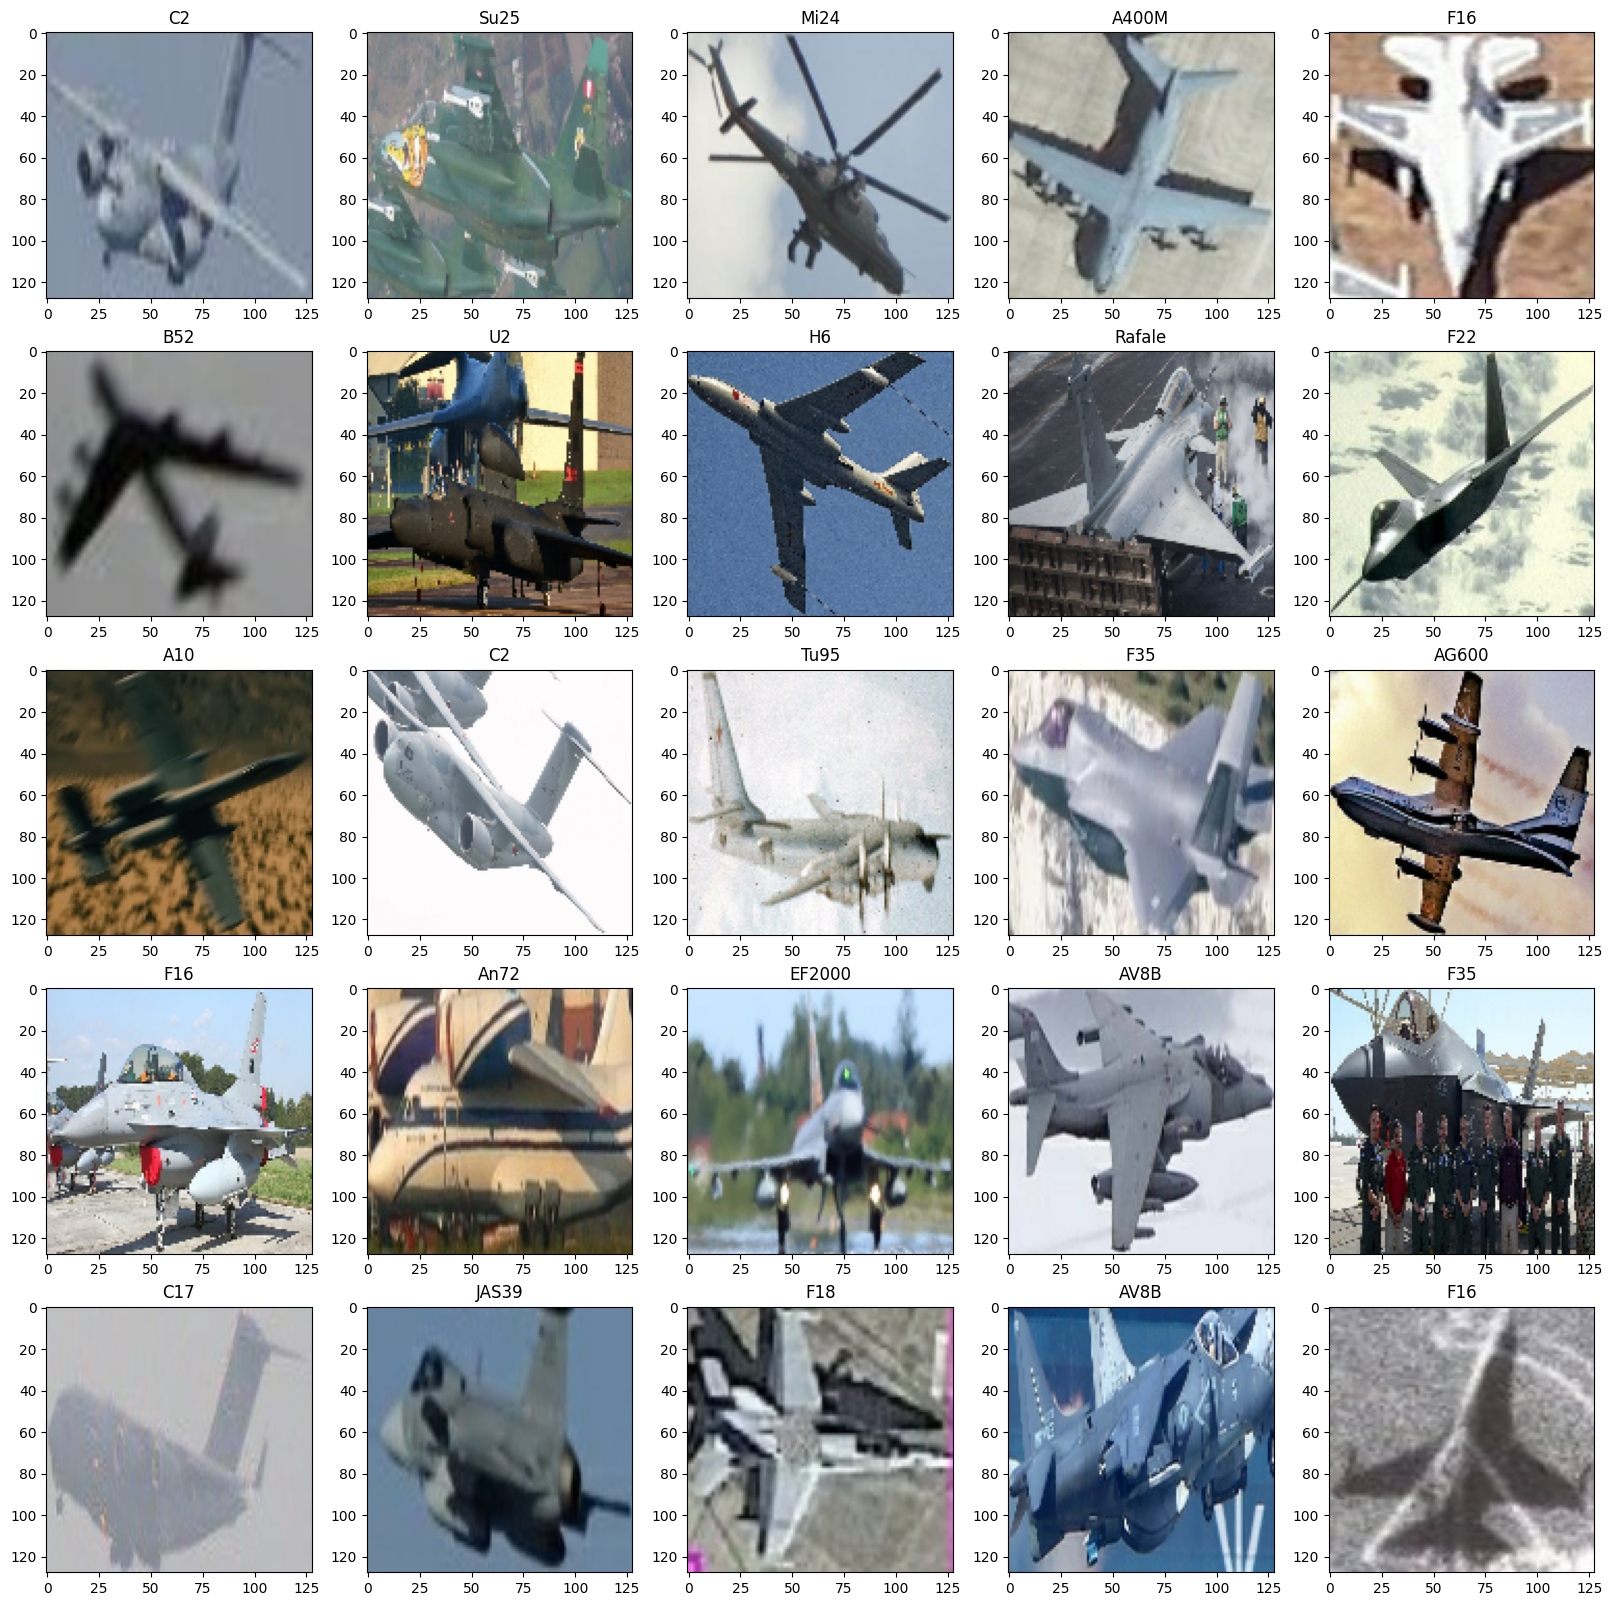

In [14]:
class_names = train_df.class_names

plt.figure(figsize = (20, 20))
for images, labels in train_df.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])

In [16]:
autotune = tf.data.AUTOTUNE
pf_train = train_df.prefetch(buffer_size = autotune)
pf_test = test_df.prefetch(buffer_size = autotune)
pf_val = validation_df.prefetch(buffer_size = autotune)

In [18]:
data_augmentation = tf.keras.Sequential()
data_augmentation.add(layers.RandomRotation(0.3))
data_augmentation.add(layers.RandomFlip("horizontal_and_vertical"))

In [20]:
image_size = (128, 128)
image_shape = image_size + (3,)

In [21]:
preprocess_input = applications.resnet50.preprocess_input

In [24]:
base_model = applications.ResNet50(input_shape = image_shape, include_top = False, weights = 'imagenet')

In [44]:
base_model.trainable = False

In [26]:
nclass = len(class_names)
global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(nclass, activation = 'softmax')

In [28]:
inputs = tf.keras.Input(shape = image_shape)
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x)
x = global_avg(x)
outputs = output_layer(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 128, 128)  │          0 │ input_layer_5[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 128, 128)  │          0 │ input_layer_5[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 128, 128)  │          0 │ input_layer_5[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 128, 128,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 128,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 4, 4,      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[1][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 80)        │    163,920 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,751,632 (90.61 MB)

 Trainable params: 163,920 (640.31 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [31]:
image_file = '/kaggle/working/model_plot.png'
plot_model(model, to_file = image_file, show_shapes = True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [33]:
optimizer = optimizers.Adam(learning_rate = optimizers.schedules.CosineDecay(0.001, 500))
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

In [34]:
history = model.fit(pf_train, validation_data = (pf_val), epochs = 1)

949/949 ━━━━━━━━━━━━━━━━━━━━ 491s 511ms/step - accuracy: 0.2323 - loss: 3.6540 - val_accuracy: 0.3547 - val_loss: 2.6198


In [35]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [36]:
optimizer = optimizers.RMSprop(learning_rate = optimizers.schedules.CosineDecay(0.001, 500))
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

In [37]:
ft_epoch = 1
n_epochs =+ ft_epoch

history_fine = model.fit(pf_train, validation_data = (pf_val), epochs = n_epochs, initial_epoch = history.epoch[-1])

949/949 ━━━━━━━━━━━━━━━━━━━━ 929s 963ms/step - accuracy: 0.3929 - loss: 2.5251 - val_accuracy: 0.6445 - val_loss: 1.3469


In [42]:
#mage_batch,label_batch = next(pf_train)
image_batch, label_batch = pf_test.as_numpy_iterator().next()
pred_labels = np.argmax(model.predict(image_batch), axis = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


In [43]:
lab_and_pred = np.transpose(np.vstack((label_batch, pred_labels)))
print(lab_and_pred)


[[16 16]
 [58 29]
 [28 26]
 [30 28]
 [26 26]
 [21 21]
 [14 14]
 [70 70]
 [33 33]
 [29 29]
 [29 28]
 [ 0  0]
 [19 50]
 [14 14]
 [ 0  4]
 [28 28]
 [54  2]
 [ 9  9]
 [ 1  1]
 [ 1  4]
 [56  9]
 [ 0  0]
 [54 54]
 [14 14]
 [67 67]]


In [45]:
model.save('path_to_save_model.h5')

test_loss, test_accuracy = model.evaluate(pf_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

test_images, test_labels = next(pf_test.as_numpy_iterator())
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

comparison = np.vstack((test_labels, predicted_labels)).T
print(comparison)

95/95 ━━━━━━━━━━━━━━━━━━━━ 43s 421ms/step - accuracy: 0.6314 - loss: 1.4240
Test Loss: 1.437055230140686
Test Accuracy: 0.6265262961387634
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
[[ 0  0]
 [27 27]
 [57 57]
 [44 45]
 [30 31]
 [28 28]
 [20 20]
 [60 60]
 [32 28]
 [27 27]
 [56  9]
 [64 32]
 [66 52]
 [26 29]
 [ 4  4]
 [19 19]
 [67 67]
 [25 66]
 [57 57]
 [45 64]
 [ 4 64]
 [26 26]
 [56 61]
 [ 6  8]
 [29 31]]


In [46]:
import random

# Function to determine the best plains (classes) based on model accuracy
def get_best_plains(model, test_df, class_names):
    # Evaluate the model on the test set
    test_images, test_labels = next(test_df.as_numpy_iterator())
    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Calculate accuracy for each class
    class_accuracy = {}
    for i, class_name in enumerate(class_names):
        class_indices = np.where(test_labels == i)[0]
        if len(class_indices) > 0:
            correct_predictions = np.sum(predicted_labels[class_indices] == test_labels[class_indices])
            class_accuracy[class_name] = correct_predictions / len(class_indices)
        else:
            class_accuracy[class_name] = 0  # If no samples for this class in the test set

    # Sort classes by accuracy (best to worst)
    sorted_classes = sorted(class_accuracy.items(), key=lambda x: x[1], reverse=True)
    return sorted_classes

# Function to simulate combat between two plains
def simulate_combat(plain1, plain2, class_accuracy):
    # Determine the winner based on accuracy
    accuracy1 = class_accuracy[plain1]
    accuracy2 = class_accuracy[plain2]

    if accuracy1 > accuracy2:
        return plain1
    elif accuracy2 > accuracy1:
        return plain2
    else:
        return "Tie"  # If both have the same accuracy

# Main function to run the combat simulation
def combat_simulation(model, test_df, class_names):
    # Get the best plains based on accuracy
    best_plains = get_best_plains(model, test_df, class_names)
    best_plains = [plain[0] for plain in best_plains]  # Extract class names

    # Randomly select two plains for combat
    selected_plains = random.sample(best_plains, 2)
    print(f"Selected plains for combat: {selected_plains[0]} vs {selected_plains[1]}")

    # Simulate combat
    winner = simulate_combat(selected_plains[0], selected_plains[1], dict(best_plains))
    print(f"The winner is: {winner}")

# Run the combat simulation
combat_simulation(model, pf_test, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
Selected plains for combat: F16 vs P3


ValueError: dictionary update sequence element #0 has length 5; 2 is required